Import library dan pemanggilan dataset di lokal

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
data_dir = 'C:/Users/User/Documents/Dataset Skripsi/peluru-fix/trainval'
os.listdir(data_dir)

['Critical', 'Good']

Intall GPU version of tensorflow

In [ ]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device:  {}'.format(tf.test.gpu_device_name()))

else:
    print("Please install GPU version of TF")

Default GPU Device:  /device:GPU:0


Mengecheck GPU yang aviable

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


Proses mempersiapkan dataset dan augmentasi data serta membuat flow datanya

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = (224, 224)
batch_size = 4

train_datagen = ImageDataGenerator( rescale=1./255, validation_split=0.112,
                                    horizontal_flip = True,
                                    vertical_flip = True,
                                    brightness_range = (0.5, 2)
                                  )

train_generator = train_datagen.flow_from_directory(
        data_dir, seed=10,
        target_size=image_size,
        batch_size=batch_size,
        subset='training',
        class_mode='binary')

validation_generator = train_datagen.flow_from_directory(
        data_dir, seed=10,
        target_size=image_size,
        batch_size=batch_size,
        subset='validation',
        class_mode='binary')

Found 1587 images belonging to 2 classes.
Found 199 images belonging to 2 classes.


Melakukan convert Keras generator ke NumpyArray

In [ ]:
def get_array(generator, y_only=True):
    data_listX = []
    data_listY = []
    batch_index = 0
    while batch_index <= generator.batch_index:
        data = generator.next()
        if not y_only:
            data_listX.append(data[0])
        data_listY.append(data[1])
        batch_index = batch_index + 1
    if not y_only:
        return np.concatenate(data_listX,0), np.concatenate(data_listY,0)
    return np.concatenate(data_listY,0)
# now, data_array is the numeric data of whole images label
X_train, y_train = get_array(train_generator, y_only=False)
X_valid, y_valid = get_array(validation_generator, y_only=False)

Membuat struktur convolution neural network menggunakan mobilenetv2

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
from tensorflow.keras.applications import MobileNetV2, mobilenet_v2

inputs = layers.Input(shape=(*image_size,3))
backbone = mobilenet_v2.MobileNetV2(include_top=False, input_tensor=inputs, weights='imagenet')
x = backbone.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu6')(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

Compile model

In [ ]:
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.metrics import TruePositives, TrueNegatives, FalsePositives, FalseNegatives

model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.0001),
              metrics=['acc','AUC', TruePositives(name='TP'), TrueNegatives(name='TN'), FalsePositives(name='FP'), FalseNegatives(name='FN')])

# checkpoint
filepath="1.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_TP', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

C:\Users\User\anaconda3\envs\ammoqc\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### Training

Proses training model

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    class_weight='balanced', classes=np.unique(y_train), y = y_train)
class_weights = dict(enumerate(class_weights))

In [ ]:
model.fit(
      X_train, y_train,
      epochs=25,
      batch_size=batch_size,
      validation_data=(X_valid, y_valid),
      callbacks=callbacks_list,
      class_weight=class_weights,
      verbose=2)

Epoch 1/25

Epoch 1: val_TP improved from -inf to 22.00000, saving model to weights_best_resnet.h5
33/33 - 12s - loss: 0.6529 - acc: 0.7348 - auc: 0.7906 - TP: 73.0000 - TN: 24.0000 - FP: 16.0000 - FN: 19.0000 - val_loss: 0.4285 - val_acc: 0.8750 - val_auc: 0.9841 - val_TP: 22.0000 - val_TN: 6.0000 - val_FP: 4.0000 - val_FN: 0.0000e+00 - 12s/epoch - 366ms/step
Epoch 2/25

Epoch 2: val_TP did not improve from 22.00000
33/33 - 13s - loss: 0.1922 - acc: 0.9242 - auc: 0.9804 - TP: 84.0000 - TN: 38.0000 - FP: 2.0000 - FN: 8.0000 - val_loss: 0.4114 - val_acc: 0.7188 - val_auc: 0.9841 - val_TP: 22.0000 - val_TN: 1.0000 - val_FP: 9.0000 - val_FN: 0.0000e+00 - 13s/epoch - 397ms/step
Epoch 3/25

Epoch 3: val_TP did not improve from 22.00000
33/33 - 13s - loss: 0.2033 - acc: 0.9091 - auc: 0.9732 - TP: 86.0000 - TN: 34.0000 - FP: 6.0000 - FN: 6.0000 - val_loss: 0.3818 - val_acc: 0.6875 - val_auc: 1.0000 - val_TP: 22.0000 - val_TN: 0.0000e+00 - val_FP: 10.0000 - val_FN: 0.0000e+00 - 13s/epoch - 391

visualisasi hasil proses training dan validation

Text(0.5, 1.0, 'Training and validation loss')

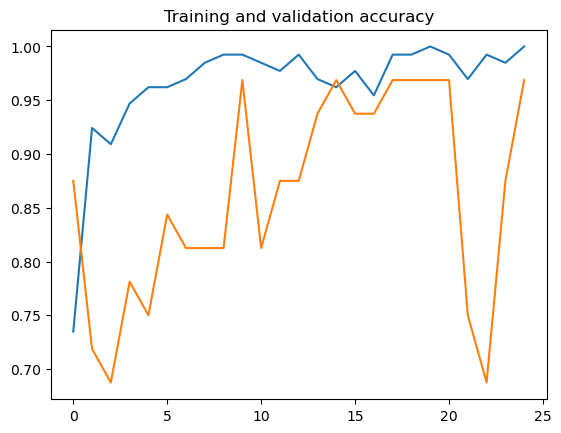

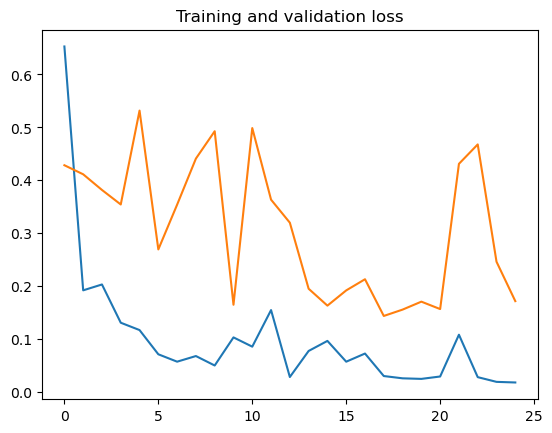

In [ ]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = model.history.history['acc']
val_acc = model.history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

Melakukan penyimpanan model yang telah dilatih dan divalidasi

In [ ]:
model.save('1.h5')